### ISC CamCan Suspense

The goal of this notebook is to run a sliding-window ISC 

### setting up modules

In [21]:
import os, sys, scipy, nilearn, warnings
warnings.filterwarnings("ignore")
import numpy as np
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

from camcan_utils import *

### set up files

In [22]:
suspense_file = '../data/avg_suspense.npy'
dict_file     = '../data/timeseries_dictionary.npy'
ts_data_file  = '../data/ts_data.npy'
shen_dictionary_file  = '../data/shen_dictionary.npy'
shen_atlas_filename =  '../data/shen_2mm_268_parcellation.nii'
sample_file         =  '../data/func.nii'

### load data 
see description in notebook on main ISC analysis

In [23]:
ts_data = np.load(ts_data_file)
n_tr, n_regions, n_subjs = ts_data.shape
n_regions

268

### compute dynamic ISC analysis

In [3]:
# if precomputed
dyn_isc_file  = '../data/dyn_isc_dict.npy'
dyn_isc_dict = np.load(dyn_isc_file).item() 
dyn_isc_result_all = dyn_isc_dict['dyn_isc_result_all']
dyn_isc_result = dyn_isc_dict['dyn_isc_result_splithalf']

In [24]:
### compute main sliding window analysis across full data (takes a while - hence precomputed)
dyn_isc_result_all = camcan_sliding_isc(ts_data[:,:,:])

#### set up two sub-samples (for consistency check)
subject_chunks = [[0, int(n_subjs/2)],
                  [int(n_subjs/2), n_subjs]]

n_iterations = len(subject_chunks)

dyn_isc_result = np.zeros((n_iterations, n_tr, n_regions))

sub_index = np.arange(n_subjs)
np.random.shuffle(sub_index)

for curr_sample in range(n_iterations): 
    print('Working on subgroup #', (curr_sample +1 ), ' of ', n_iterations)
    people_to_use = np.arange(subject_chunks[curr_sample][0], subject_chunks[curr_sample][1], 1)

    D = ts_data[:,:,sub_index[people_to_use] ]
    dyn_isc_result[curr_sample, :, :] = camcan_sliding_isc(D)

### save results - because computing them every time from scratch takes a lot of time 
### we save the output here so we can load it quicker later on

dyn_isc_dict = {}
dyn_isc_dict['dyn_isc_result_all'] = dyn_isc_result_all
dyn_isc_dict['dyn_isc_result_splithalf'] = dyn_isc_result

np.save('../data/dyn_isc_dict.npy', dyn_isc_dict) 

Assuming 494 subjects with 193 time points and 268 voxel(s) or ROI(s).
Will compute sliding window analysis with a window length of -7 and +7 samples.
99%Working on subgroup # 1  of  2
Assuming 247 subjects with 193 time points and 268 voxel(s) or ROI(s).
Will compute sliding window analysis with a window length of -7 and +7 samples.
99%Working on subgroup # 2  of  2
Assuming 247 subjects with 193 time points and 268 voxel(s) or ROI(s).
Will compute sliding window analysis with a window length of -7 and +7 samples.
99%

### plot dynISC vs CRM

Alignment: 0.47


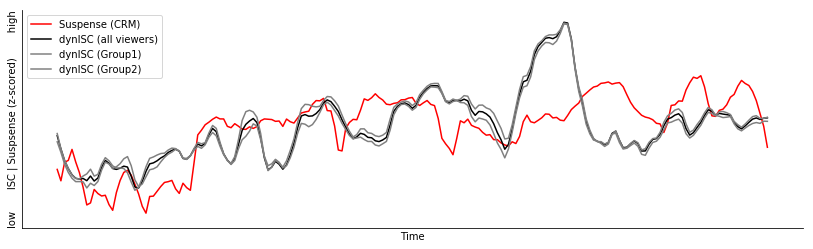

In [6]:
f = plt.figure(figsize=(14,4))
ax1 = f.add_subplot(111)

suspense = np.load(suspense_file)

ax1.plot(scipy.stats.zscore(suspense),   color = 'red',   label = 'Suspense (CRM)' );
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result_all[:,:], axis = 1)), color = 'black', label = 'dynISC (all viewers)'   );
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result[0,:,:], axis = 1)),   color = 'gray',  label = 'dynISC (Group1)' );
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result[1,:,:], axis = 1)),   color = 'gray',  label = 'dynISC (Group2)');

plt.legend(loc = 0)
plt.ylim(-3, 3.5)
plt.xlabel('Time')
plt.ylabel('low       ISC | Suspsense (z-scored)        high')
plt.xticks([]);
plt.yticks([]);
sns.despine()

alignment = np.corrcoef(
                (scipy.stats.zscore(np.nanmean(dyn_isc_result_all[:,:], axis = 1)) ),
                 scipy.stats.zscore(suspense) )[0,1]

print('Alignment: ' + str(np.round(alignment, 2)) )

#### examine within specific regions

0.5329420764345074


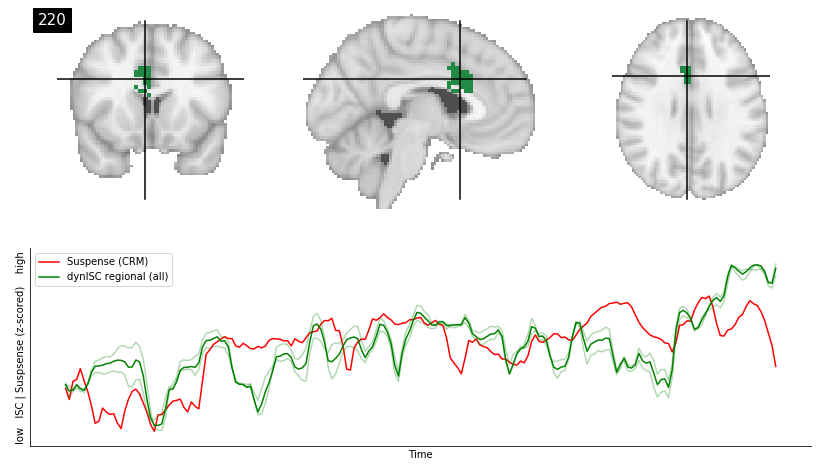

In [8]:
curr_region = 6 #(220 = amcc, 6 - frontal)

shen_dictionary = np.load(shen_dictionary_file).item()
curr_title = shen_dictionary[curr_region + 1]['name'] 
curr_coords = shen_dictionary[curr_region + 1]['coords'] 


f = plt.figure(figsize=(14,8))
# plot where that region is
region_vector = np.zeros((1,268))
region_vector[0,curr_region] = 0.5

shen_masker = NiftiLabelsMasker(labels_img=shen_atlas_filename);
shen_masker.fit_transform(sample_file);
region_img = shen_masker.inverse_transform(region_vector);

curr_title = shen_dictionary[curr_region + 1]['name'] 
curr_coords = shen_dictionary[curr_region + 1]['coords'] 
    
ax1 = f.add_subplot(211)
    
nilearn.plotting.plot_stat_map(nilearn.image.index_img(region_img,0), 
                                       threshold = 0.45, 
                                       vmax = 1., 
                                       draw_cross = True,
                                       colorbar = False,
                                       cmap = 'Greens', #'RdPu'
                                       annotate = False,
                                       cut_coords = curr_coords,
                                       title = str(curr_region),
                                       axes = ax1);

ax2 = f.add_subplot(212)
ax2.plot(scipy.stats.zscore(suspense), color = 'red',   label = 'Suspense (CRM)');
ax2.plot(scipy.stats.zscore(dyn_isc_result_all[:,curr_region]),             color = 'green', label = 'dynISC regional (all)');
ax2.plot(scipy.stats.zscore(dyn_isc_result[0,:,curr_region]).T,             color = 'green', alpha = 0.3, );#label = 'dynISC regional (Group1)');
ax2.plot(scipy.stats.zscore(dyn_isc_result[1,:,curr_region]).T,            color = 'green',  alpha = 0.3, );#label = 'dynISC regional (Group2)');

plt.legend(loc = 0)
plt.ylim(-3, 3)
plt.xlabel('Time')
plt.ylabel('low   ISC | Suspsense (z-scored)    high')
plt.xticks([]);
plt.yticks([]);
sns.despine()
    
alignment = np.corrcoef(
                    (scipy.stats.zscore(dyn_isc_result_all[:,curr_region]) ),
                     scipy.stats.zscore(suspense))[0,1]
print(alignment) 

In [ ]:
curr_region = 220 

curr_title = shen_dictionary[curr_region + 1]['name'] 
curr_coords = shen_dictionary[curr_region + 1]['coords'] 

f = plt.figure(figsize=(14,8))
region_vector = np.zeros((1,268))
region_vector[0,curr_region] = 0.5
region_img = shen_masker.inverse_transform(region_vector);
curr_title = shen_dictionary[curr_region + 1]['name'] 
curr_coords = shen_dictionary[curr_region + 1]['coords'] 
    
ax1 = f.add_subplot(211)  
nilearn.plotting.plot_stat_map(nilearn.image.index_img(region_img,0), 
                                       threshold = 0.45, 
                                       vmax = 1., 
                                       draw_cross = True,
                                       colorbar = False,
                                       cmap = 'RdPu',
                                       annotate = False,
                                       cut_coords = curr_coords,
                                       title = str(curr_region),
                                       axes = ax1);

ax2 = f.add_subplot(212)
ax2.plot(scipy.stats.zscore(suspense), color = 'red',   label = 'Suspense (CRM)');
ax2.plot(scipy.stats.zscore(dyn_isc_result_all[:,curr_region]),             color = 'purple', label = 'dynISC regional (all)');
ax2.plot(scipy.stats.zscore(dyn_isc_result[0,:,curr_region]).T,             color = 'purple', alpha = 0.3, );#label = 'dynISC regional (Group1)');
ax2.plot(scipy.stats.zscore(dyn_isc_result[1,:,curr_region]).T,            color = 'purple',  alpha = 0.3, );#label = 'dynISC regional (Group2)');

plt.legend(loc = 0)
plt.ylim(-3, 3)
plt.xlabel('Time')
plt.ylabel('low   ISC | Suspsense (z-scored)    high')
plt.xticks([]);
plt.yticks([]);
sns.despine()
    
alignment = np.corrcoef(
                    (scipy.stats.zscore(dyn_isc_result_all[:,curr_region]) ),
                     scipy.stats.zscore(suspense))[0,1]
print(alignment) 

In [25]:
'''for curr_region in res[:]:
    #print(curr_region)

    # plot where that region is
    shen_dictionary = np.load(shen_dictionary_file).item()
    #shen_dictionary[curr_region]['name'] 

    region_vector = np.zeros((1,268))
    region_vector[0,curr_region] = 0.5

    shen_masker = NiftiLabelsMasker(labels_img=shen_atlas_filename);
    shen_masker.fit_transform(sample_file);
    region_img = shen_masker.inverse_transform(region_vector);

    curr_title = shen_dictionary[curr_region + 1]['name'] 
    curr_coords = shen_dictionary[curr_region + 1]['coords'] 
    
    f = plt.figure(figsize = (14,2))
    ax1 = f.add_subplot(121)
    
    nilearn.plotting.plot_stat_map(nilearn.image.index_img(region_img,0), 
                                       threshold = 0.4, 
                                       vmax = 1., 
                                       draw_cross = True,
                                       colorbar = False,
                                       cmap = 'Greens',
                                       annotate = False,
                                       cut_coords = curr_coords,
                                       title = str(curr_region),
                                       axes = ax1);
    #plt.show()


    #f = plt.figure(figsize=(10,5))
    ax2 = f.add_subplot(122)

    ax2.plot(scipy.stats.zscore(suspense), color = 'red',   label = 'Suspense (CRM)');
    ax2.plot(scipy.stats.zscore(dyn_isc_result_all[:,curr_region]),             color = 'green', label = 'dynISC regional (all)');
    ax2.plot(scipy.stats.zscore(dyn_isc_result[0,:,curr_region]).T,             color = 'green', alpha = 0.3, label = 'dynISC regional (Group1)');
    ax2.plot(scipy.stats.zscore(dyn_isc_result[1,:,curr_region]).T,            color = 'green',  alpha = 0.3, label = 'dynISC regional (Group2)');

    #plt.legend(loc = 4)
    plt.ylim(-3, 3)
    plt.xlabel('Time')
    plt.ylabel('low   ISC | Suspsense (z-scored)    high')
    plt.xticks([]);
    plt.yticks([]);
    

    alignment = np.corrcoef(
                    (scipy.stats.zscore(dyn_isc_result_all[:,curr_region]) ),
                     scipy.stats.zscore(suspense))[0,1]
    
    plt.title(curr_title[6:30] + ' Alignment: ' + str(np.round(alignment,2)))
    sns.despine()

    #print('Alignment: ' + str(np.round(alignment,2)) )'''
# .

"for curr_region in res[:]:\n    #print(curr_region)\n\n    # plot where that region is\n    shen_dictionary = np.load(shen_dictionary_file).item()\n    #shen_dictionary[curr_region]['name'] \n\n    region_vector = np.zeros((1,268))\n    region_vector[0,curr_region] = 0.5\n\n    shen_masker = NiftiLabelsMasker(labels_img=shen_atlas_filename);\n    shen_masker.fit_transform(sample_file);\n    region_img = shen_masker.inverse_transform(region_vector);\n\n    curr_title = shen_dictionary[curr_region + 1]['name'] \n    curr_coords = shen_dictionary[curr_region + 1]['coords'] \n    \n    f = plt.figure(figsize = (14,2))\n    ax1 = f.add_subplot(121)\n    \n    nilearn.plotting.plot_stat_map(nilearn.image.index_img(region_img,0), \n                                       threshold = 0.4, \n                                       vmax = 1., \n                                       draw_cross = True,\n                                       colorbar = False,\n                                     

#### expand the regional ISC analysis to all regions

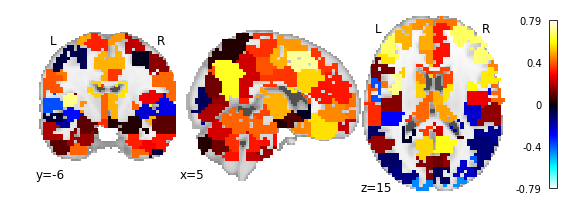

In [12]:
isc_2_crm = np.zeros((1,n_regions))
for curr_region in range(n_regions):
    isc_2_crm[0,curr_region] = np.corrcoef(dyn_isc_result_all[:, curr_region], suspense)[0,1]

isc_2_crm_img = shen_masker.inverse_transform(isc_2_crm);
nilearn.plotting.plot_stat_map(nilearn.image.index_img(isc_2_crm_img,0), 
                               vmax = 0.8, 
                               draw_cross = False,
                               #cut_coords = (-40,-50,10),
                               #annotate = False,
                               #title = "Relationship between regional dynISC and CRM ratings"
                              );

In [13]:
view = nilearn.plotting.view_img(nilearn.image.index_img(isc_2_crm_img,0) ,
                                resampling_interpolation = 'linear',
                                threshold = 0.4);
view

In [17]:
res = np.where(isc_2_crm > 0.5)[1]
res

array([  2,   6,   7,   8,  10,  13,  14,  18,  19,  20,  27,  32,  34,
        35,  42,  46,  85,  89, 112, 121, 133, 135, 136, 142, 146, 149,
       152, 153, 154, 167, 168, 183, 220, 221, 224, 239, 245, 252, 259])

In [15]:
# read in the time series data to get access to the raw BOLD activation values 
read_dictionary = np.load(dict_file).item()

subjs = list(read_dictionary.keys())
n_subjs = len(subjs)
n_tr, n_regions = read_dictionary[subjs[0]]['funcdata'].shape
n_tr_rest, n_regions = read_dictionary[subjs[0]]['funcdata_rest'].shape

ts_data = np.zeros((n_tr, n_regions, n_subjs))
ts_data_undet = np.zeros((n_tr, n_regions,n_subjs))
motion_data = np.zeros((n_tr, 6, n_subjs))

rest_list = [] 
#re-create ts_data
for curr_sub in range(n_subjs):
    curr_sub_name                = subjs[curr_sub]
    ts_data[:,:, curr_sub]       = read_dictionary[curr_sub_name]['funcdata']
    ts_data_undet[:,:, curr_sub] = read_dictionary[curr_sub_name]['funcdata_unfilt_undet_stand']
    motion_data[:,:, curr_sub]   = read_dictionary[curr_sub_name]['motion']
    if np.asarray(read_dictionary[curr_sub_name]['funcdata_rest']).shape == (n_tr_rest, n_regions):
        rest_list.append(read_dictionary[curr_sub_name]['funcdata_rest'])
        #things are a bit cumbersome for the resting state data because - due to artifact control etc, different subjects pass the threshold
        

In [18]:
m = np.mean(ts_data_undet[:, res,:], axis = 2)
m.shape

(193, 39)

In [19]:
np.where(comp_isc_act2[:,0] > 0.7)

NameError: name 'comp_isc_act2' is not defined

108
109
112
115
201
245


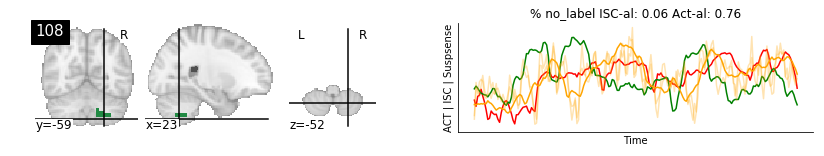

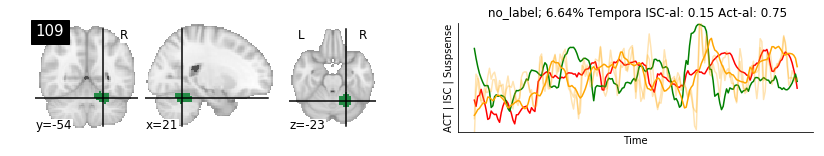

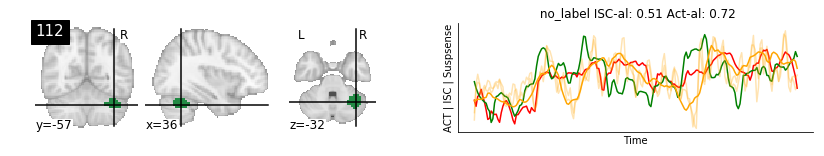

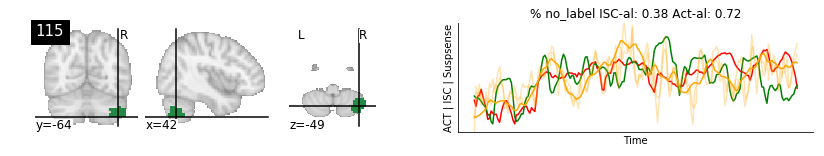

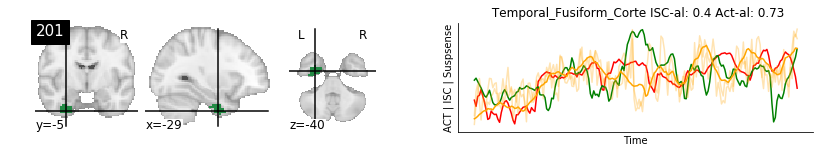

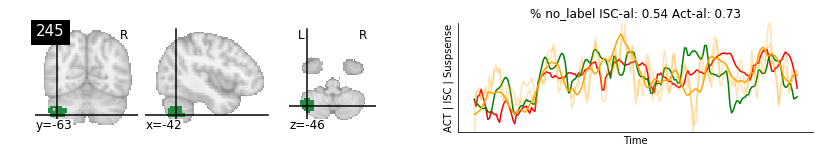

In [229]:
shen_masker = NiftiLabelsMasker(labels_img=shen_atlas_filename);
shen_masker.fit_transform(sample_file);


aa = np.where(comp_isc_act2[:,1] > 0.7)

comp_isc_act = np.zeros((268,2))

for c in range(len(aa[0])) :
    curr_region = aa[0][c]
    print(curr_region)

    # plot where that region is
    shen_dictionary = np.load(shen_dictionary_file).item()
    #shen_dictionary[curr_region]['name'] 

    region_vector = np.zeros((1,268))
    region_vector[0,curr_region] = 0.5

    region_img = shen_masker.inverse_transform(region_vector);

    curr_title = shen_dictionary[curr_region + 1]['name'] 
    curr_coords = shen_dictionary[curr_region + 1]['coords'] 
    
    #'''
    f = plt.figure(figsize = (14,2))
    ax1 = f.add_subplot(121)
    
    nilearn.plotting.plot_stat_map(nilearn.image.index_img(region_img,0), 
                                       threshold = 0.4, 
                                       vmax = 1., 
                                       draw_cross = True,
                                       colorbar = False,
                                       cmap = 'Greens',
                                       annotate = True,
                                       cut_coords = curr_coords,
                                       title = str(curr_region),
                                       axes = ax1);
    #plt.show()


    #f = plt.figure(figsize=(10,5))
    ax2 = f.add_subplot(122)

    ax2.plot(scipy.stats.zscore(suspense), color = 'red',   label = 'Suspense (CRM)');
    ax2.plot(scipy.stats.zscore(dyn_isc_result_all[:,curr_region]),             color = 'green', label = 'dynISC regional (all)');
    #ax2.plot(scipy.stats.zscore(dyn_isc_result[0,:,curr_region]).T,             color = 'green', alpha = 0.3, label = 'dynISC regional (Group1)');
    #ax2.plot(scipy.stats.zscore(dyn_isc_result[1,:,curr_region]).T,            color = 'green',  alpha = 0.3, label = 'dynISC regional (Group2)');

    
    #'''
    m1 = np.mean(ts_data_undet[:, curr_region,:248], axis = 1)
    m2 = np.mean(ts_data_undet[:, curr_region, 248:], axis = 1)
    
    m_all = np.mean(ts_data_undet[:, curr_region, :], axis = 1)
    
    roll_vals = pd.DataFrame(m_all).rolling(window = 15, center = True, win_type = 'boxcar', min_periods = 1).mean()[0].values

    
    #'''
    ax2.plot(scipy.stats.zscore(m1),            color = 'orange',  alpha = 0.3, label = 'activation regional (Group1)');
    ax2.plot(scipy.stats.zscore(m2),            color = 'orange',  alpha = 0.3, label = 'activation regional (Group1)');

    ax2.plot(scipy.stats.zscore(roll_vals),            color = 'orange', label = 'activation regional (Group1)');

    
    #plt.legend(loc = 4)
    plt.ylim(-3, 3)
    plt.xlabel('Time')
    plt.ylabel('ACT | ISC | Suspsense')
    plt.xticks([]);
    plt.yticks([]);#'''
    

    alignment = np.corrcoef(
                    (scipy.stats.zscore(dyn_isc_result_all[:,curr_region]) ),
                     scipy.stats.zscore(suspense))[0,1]
    comp_isc_act[curr_region,0] = alignment
    
    act_alignment = np.corrcoef(
                    (scipy.stats.zscore(roll_vals) ),
                     scipy.stats.zscore(suspense))[0,1]
    comp_isc_act[curr_region,1] = act_alignment
    
    plt.title(curr_title[6:30] + ' ISC-al: ' + str(np.round(alignment,2)) + ' Act-al: ' + str(np.round(act_alignment,2)))
    sns.despine()

    #print('Alignment: ' + str(np.round(alignment,2)) )

In [228]:
np.where(comp_isc_act2[:,1] > 0.7)

(array([108, 109, 112, 115, 201, 245]),)

In [38]:

comp_isc_act2 = np.zeros((268,2))

for curr_region in range(268):
    m_all = np.mean(ts_data_undet[:, curr_region, :], axis = 1)
    
    roll_vals = pd.DataFrame(m_all).rolling(window = 15, center = True, win_type = 'boxcar', min_periods = 5).mean()[0].values

  
    alignment = np.corrcoef(
                    (scipy.stats.zscore(dyn_isc_result_all[:,curr_region]) ),
                     scipy.stats.zscore(suspense))[0,1]
    comp_isc_act2[curr_region,0] = alignment
    
    act_alignment = np.corrcoef(
                    (scipy.stats.zscore(roll_vals) ),
                     scipy.stats.zscore(suspense))[0,1]
    comp_isc_act2[curr_region,1] = act_alignment
    
  

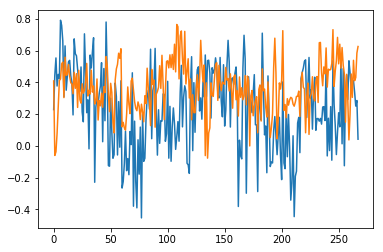

In [39]:
plt.plot(comp_isc_act2);

In [41]:
np.corrcoef(comp_isc_act2.T)

array([[1.        , 0.13537627],
       [0.13537627, 1.        ]])

In [95]:
comp_isc_act[:,0].shape

(268,)

In [42]:
isc_2_crm_reg = shen_masker.inverse_transform(np.reshape( comp_isc_act2[:,0], (1,268) ) );
view = nilearn.plotting.view_img(nilearn.image.index_img(isc_2_crm_reg,0),
                               threshold = 0.4,
                               resampling_interpolation = 'linear',
                               vmax = 0.6,
                               title = 'ISC_2_CRM tracking');
view


In [43]:
act_2_crm_reg = shen_masker.inverse_transform(np.reshape( comp_isc_act2[:,1], (1,268) ) );
view = nilearn.plotting.view_img(nilearn.image.index_img(act_2_crm_reg,0),
                               threshold = 0.4,
                               resampling_interpolation = 'linear',
                               vmax = 0.6,
                               title = 'Act_2_CRM tracking');
view

In [45]:
np.corrcoef(comp_isc_act2[:,1], comp_isc_act2[:,0])

array([[1.        , 0.13537627],
       [0.13537627, 1.        ]])

In [20]:
nilearn.plotting.plot_stat_map(nilearn.image.index_img(isc_2_crm_reg,0),
                               threshold = 0.5,
                               resampling_interpolation = 'linear',
                               vmax = 1,
                               display_mode = 'z',
                               cut_coords = [-20, -10, -5, 0, 5, 10, 15, 20, 30, 40, 50],
                               title = 'ISC_2_CRM tracking');
plt.show()
nilearn.plotting.plot_stat_map(nilearn.image.index_img(act_2_crm_reg,0),
                               threshold = 0.5,
                               resampling_interpolation = 'linear',
                               vmax = 1,
                               display_mode = 'z',
                               cut_coords = [-20, -10, -5, 0, 5, 10, 15, 20, 30, 40, 50],
                               title = 'Act_2_CRM tracking');

NameError: name 'isc_2_crm_reg' is not defined

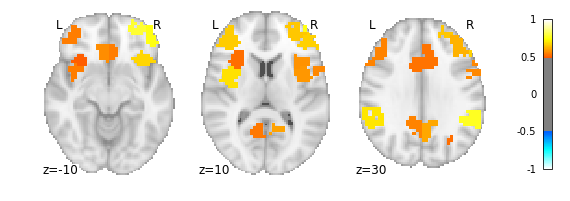

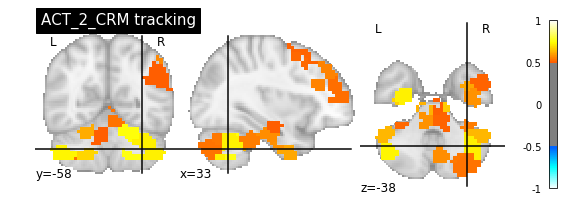

In [58]:
nilearn.plotting.plot_stat_map(nilearn.image.index_img(isc_2_crm_reg,0),
                               resampling_interpolation = 'linear',
                               threshold = 0.5,
                               vmax = 1,
                               display_mode = 'z',
                               cut_coords = [ -10, 10,  30],
                               #title = 'ISC_2_CRM tracking',
                              );

nilearn.plotting.plot_stat_map(nilearn.image.index_img(act_2_crm_reg,0),
                               resampling_interpolation = 'linear',
                               threshold = 0.5,
                               vmax = 1,
                               display_mode = 'ortho',
                               #cut_coords = [ -30, -20,  30],
                               title = 'ACT_2_CRM tracking');

In [121]:
nilearn.plotting.plot_stat_map(nilearn.image.index_img(isc_2_crm_reg,0),
                               resampling_interpolation = 'linear',
                               vmax = 1,
                               display_mode = 'z',
                               cut_coords = [-20, -10, -5, 0, 5, 10, 15, 20, 30, 40, 50],
                               title = 'ISC_2_CRM tracking');
plt.show()
nilearn.plotting.plot_stat_map(nilearn.image.index_img(act_2_crm_reg,0),
                               resampling_interpolation = 'linear',
                               vmax = 1,
                               display_mode = 'z',
                               cut_coords = [-20, -10, -5, 0, 5, 10, 15, 20, 30, 40, 50],
                               title = 'Act_2_CRM tracking');

In [131]:
#concordance / discordance of ISC and activation:
r = comp_isc_act[:,0] - comp_isc_act[:,1]
r.shape

diff_reg = shen_masker.inverse_transform(np.reshape( r, (1,268) ) );
nilearn.plotting.plot_stat_map(nilearn.image.index_img(diff_reg,0),
                               resampling_interpolation = 'linear',
                               vmax = 1,
                               display_mode = 'z',
                               cut_coords = [-20, -10, -5, 0, 5, 10, 15, 20, 30, 40, 50],
                               title = 'diff');

In [132]:
view = nilearn.plotting.view_img(nilearn.image.index_img(diff_reg,0),
                               threshold = 0.4,
                               resampling_interpolation = 'linear',
                               vmax = 0.6,
                               title = 'diff');
view

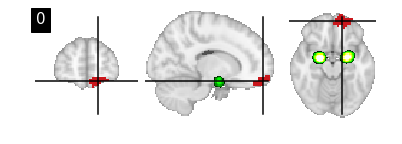

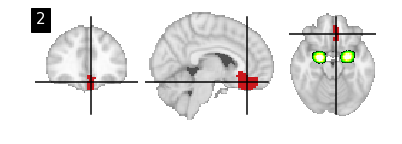

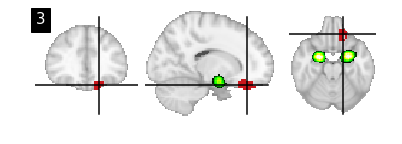

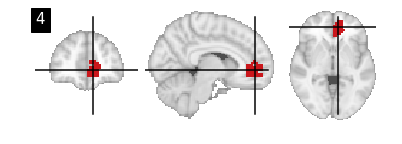

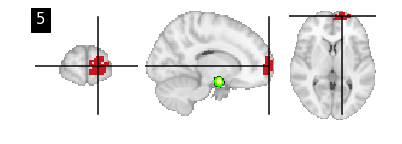

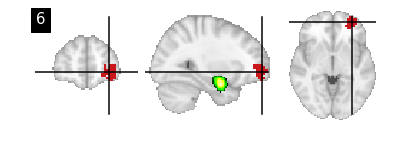

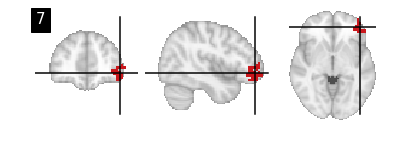

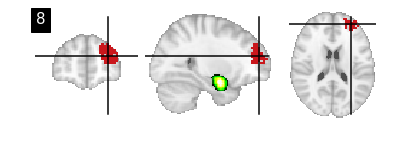

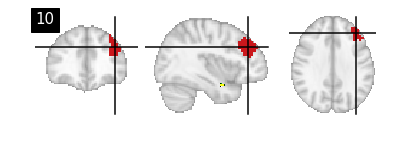

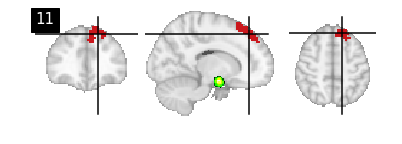

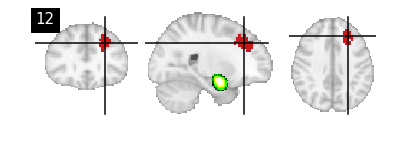

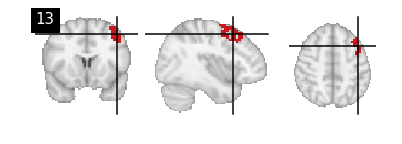

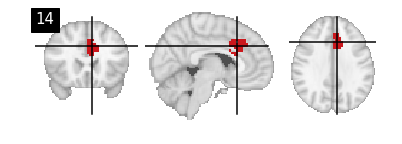

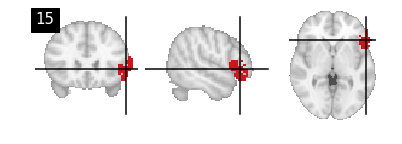

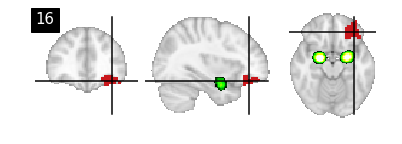

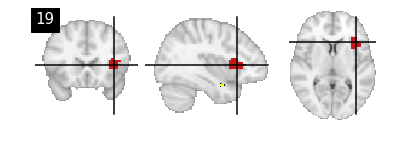

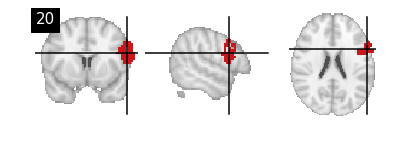

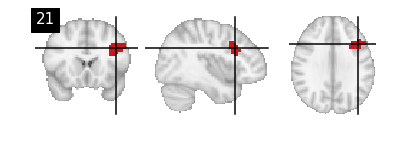

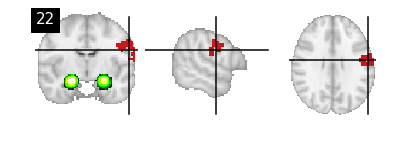

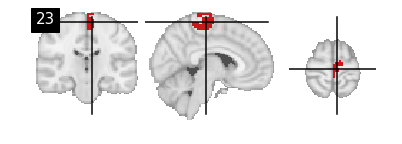

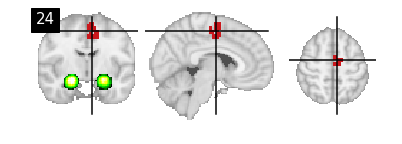

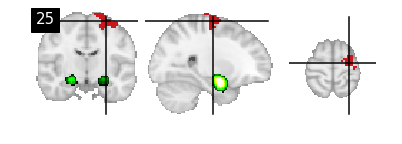

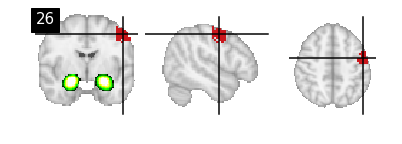

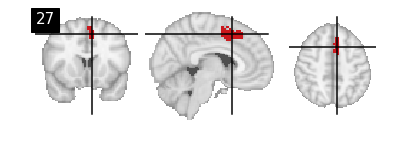

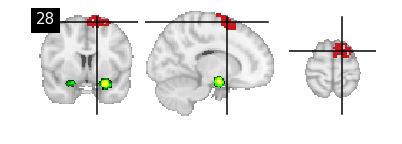

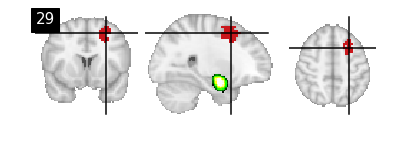

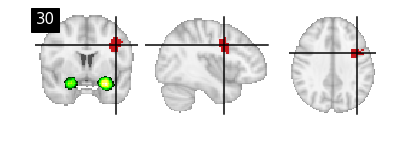

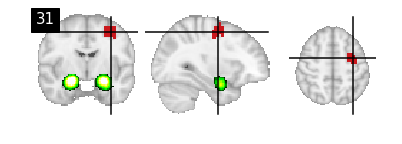

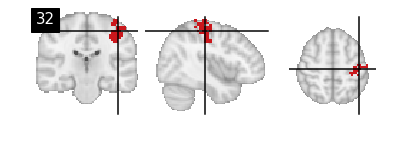

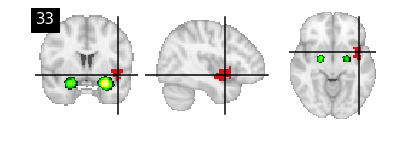

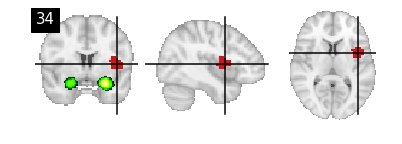

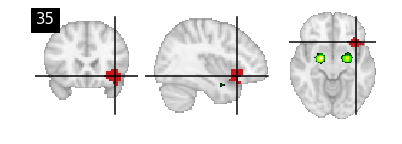

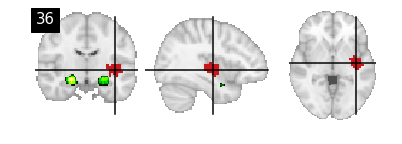

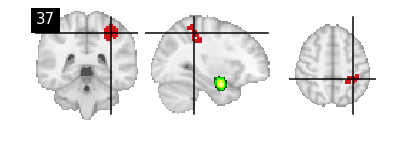

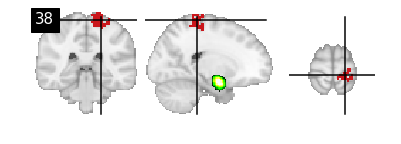

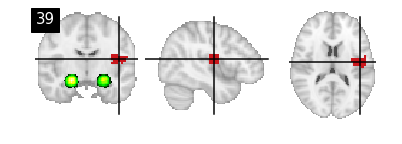

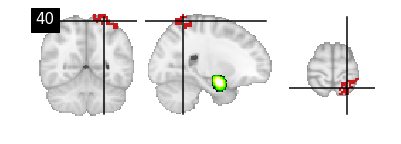

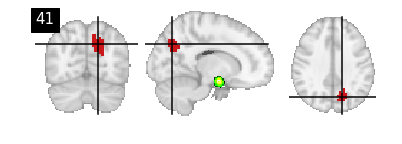

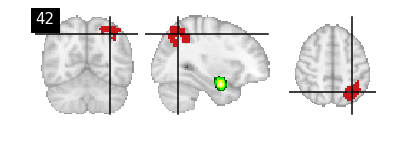

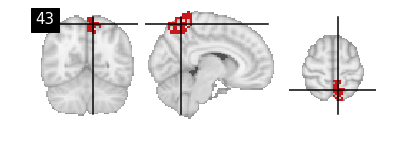

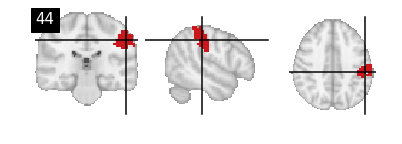

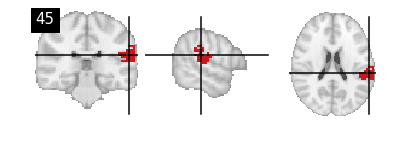

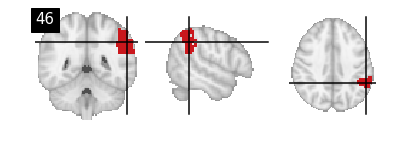

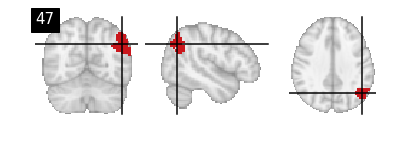

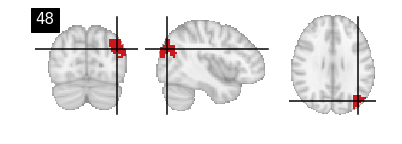

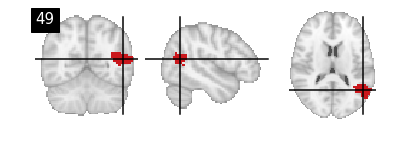

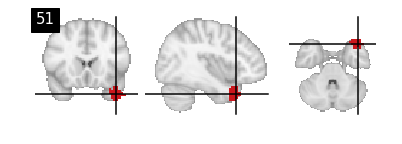

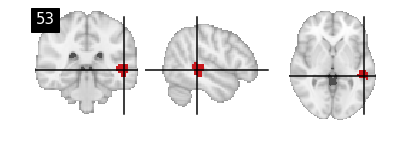

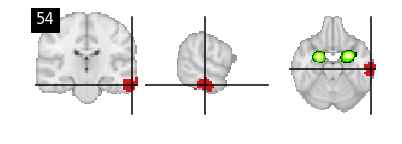

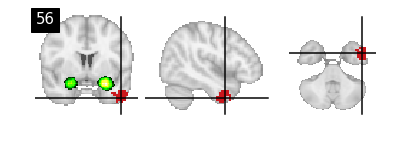

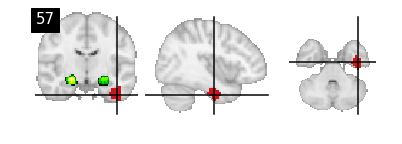

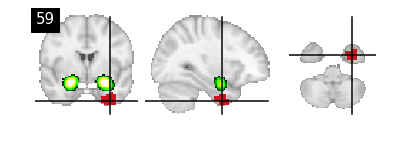

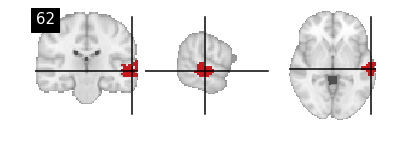

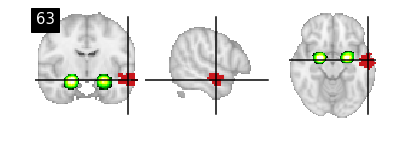

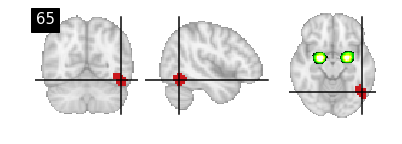

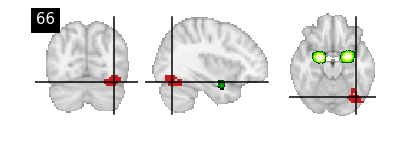

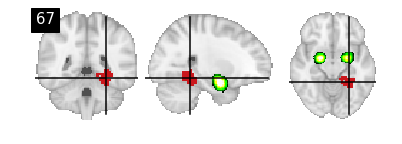

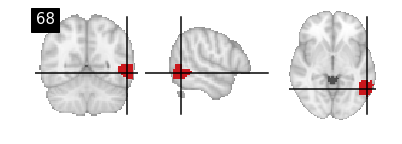

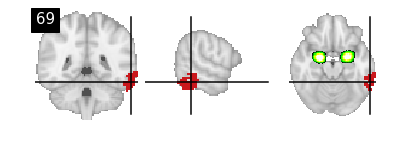

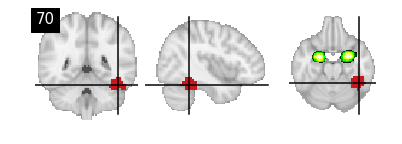

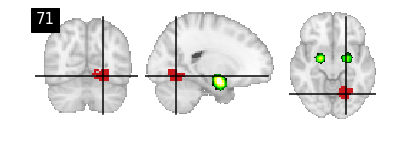

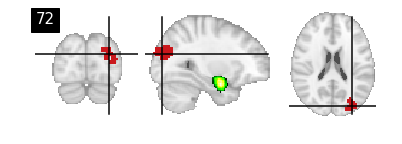

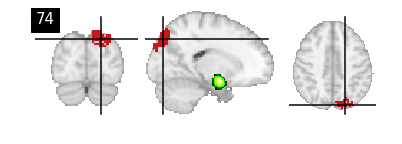

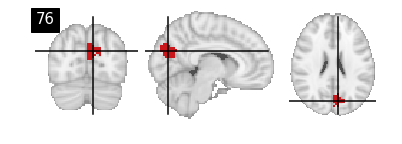

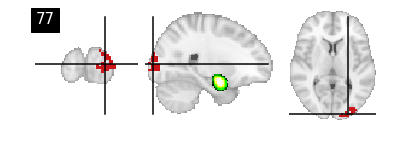

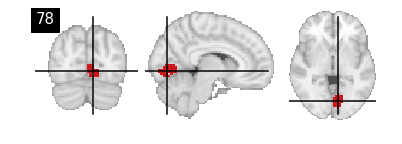

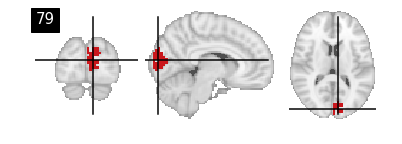

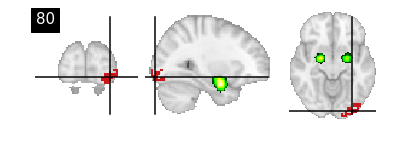

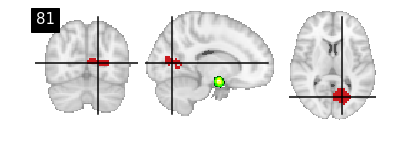

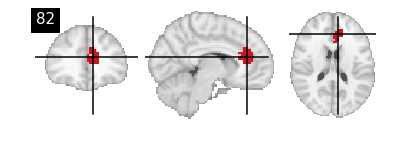

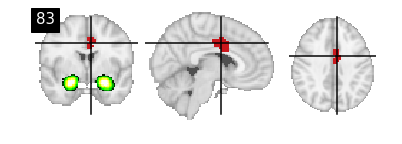

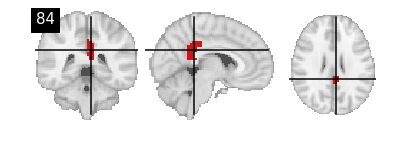

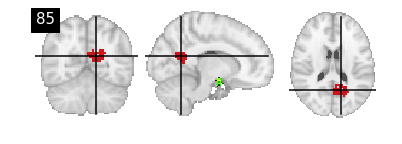

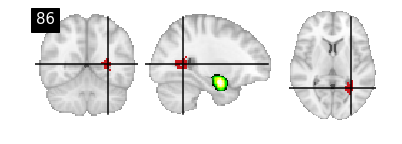

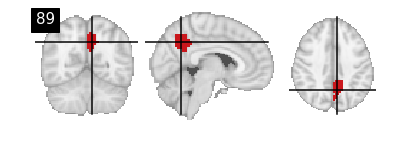

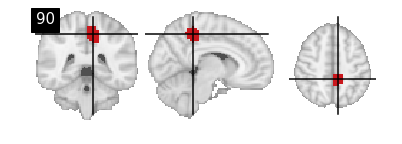

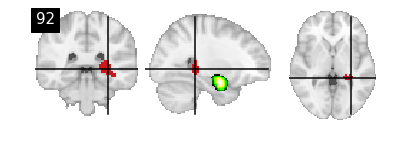

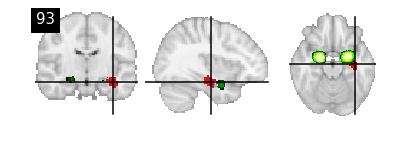

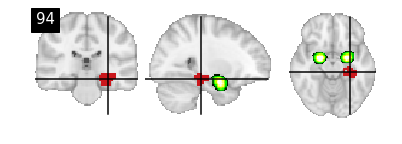

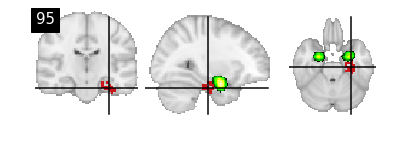

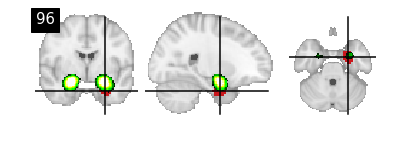

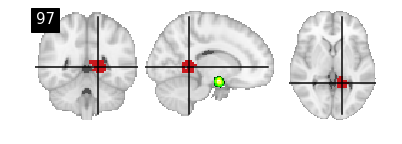

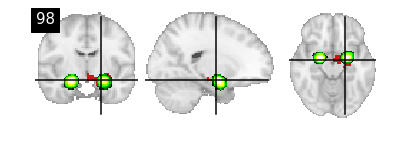

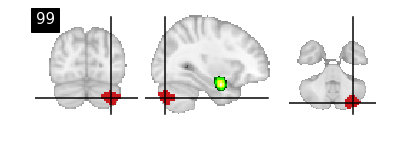

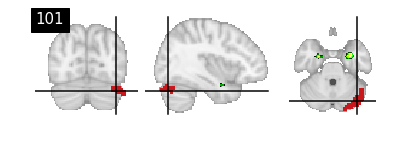

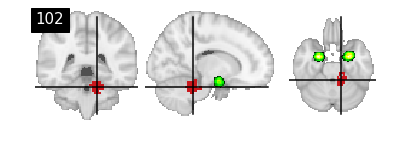

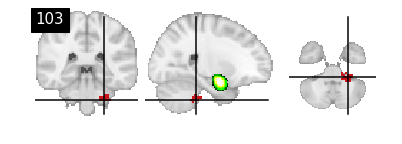

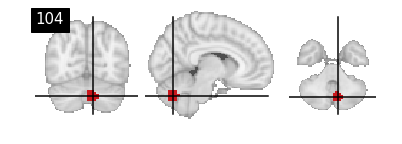

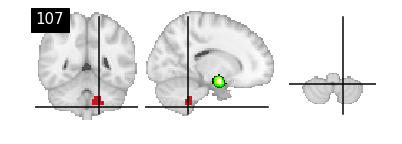

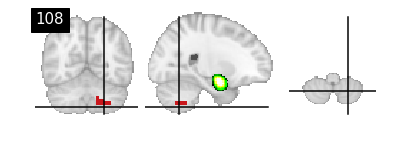

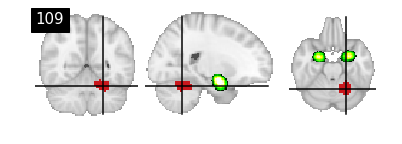

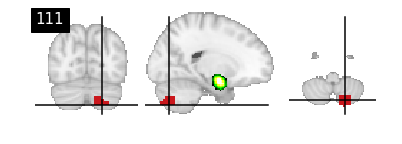

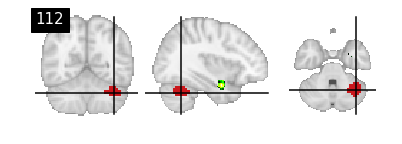

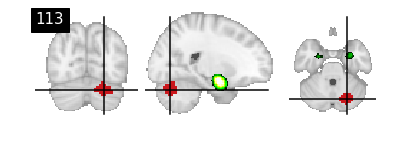

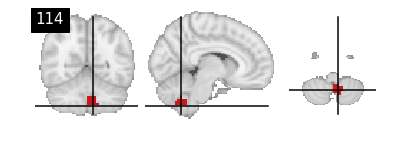

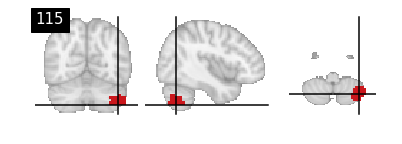

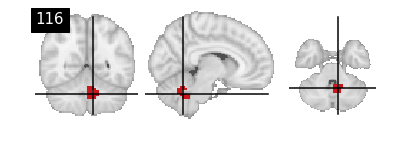

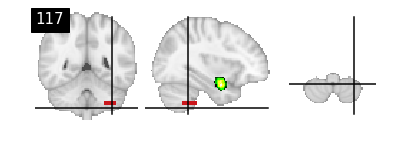

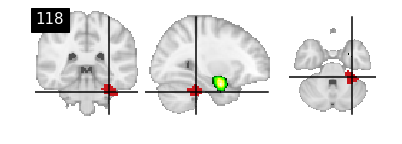

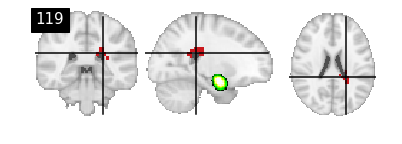

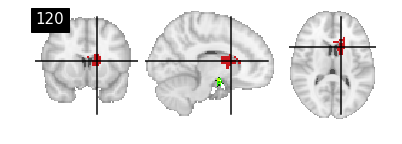

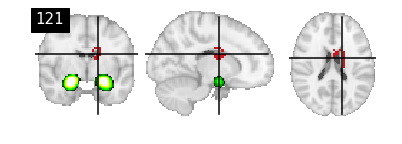

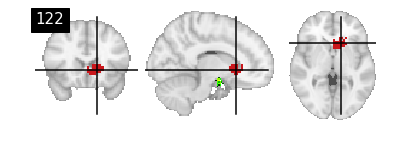

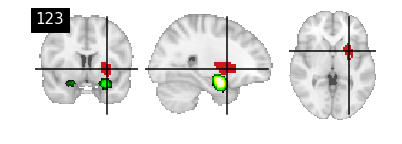

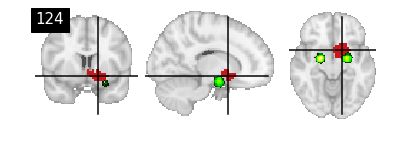

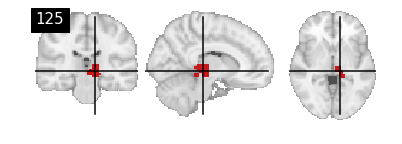

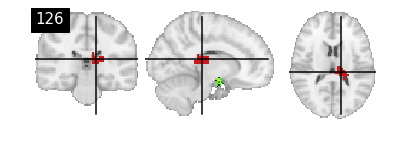

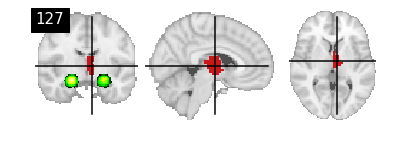

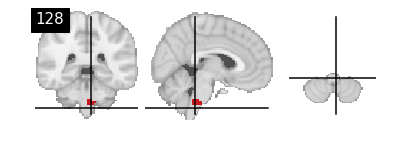

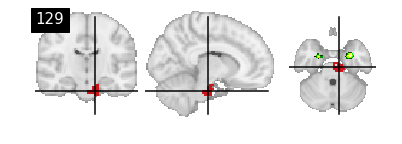

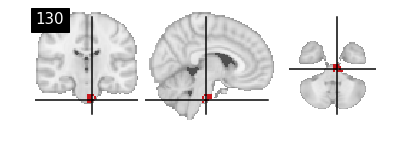

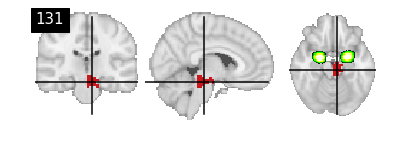

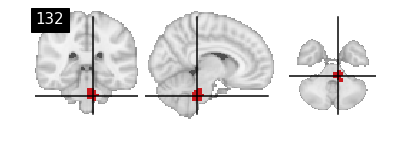

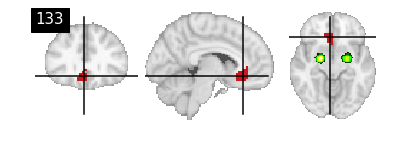

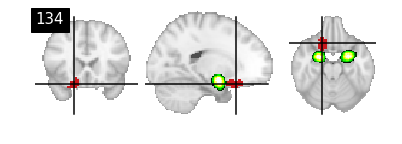

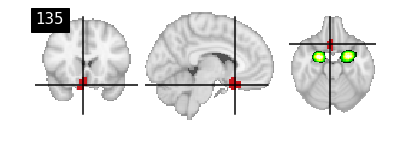

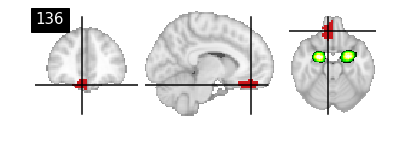

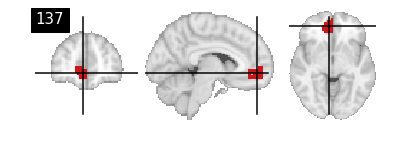

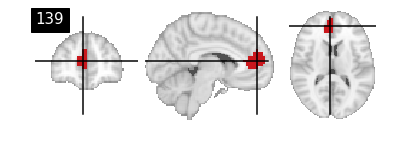

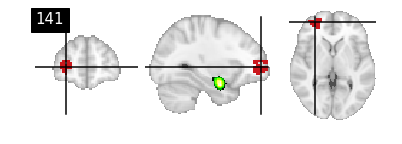

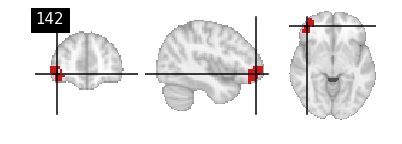

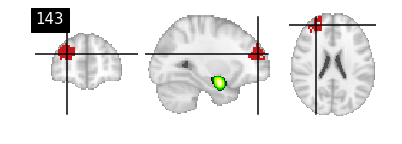

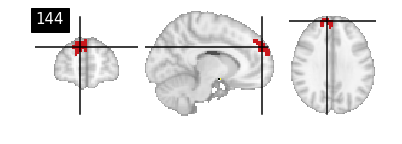

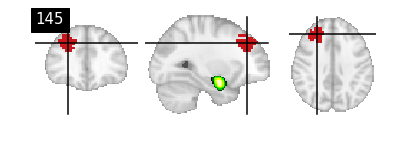

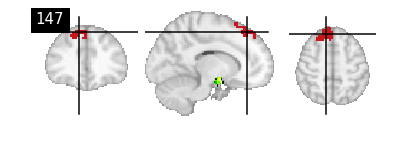

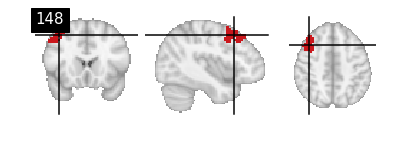

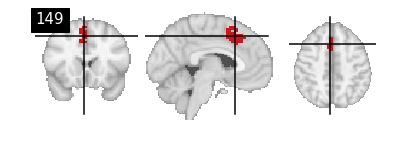

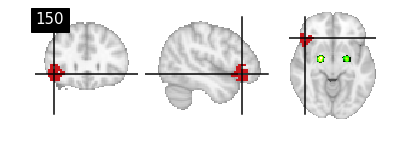

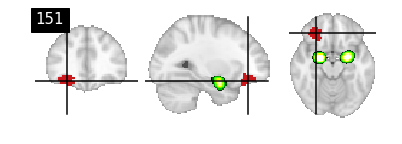

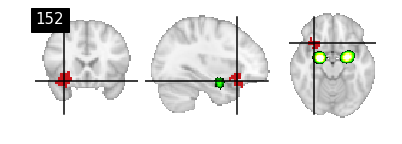

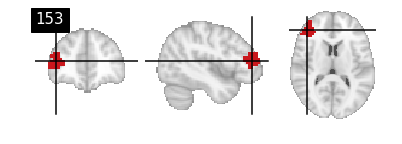

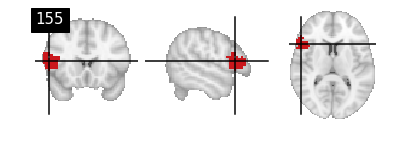

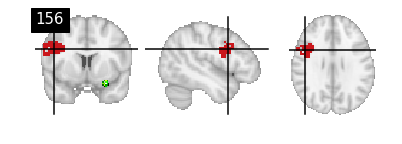

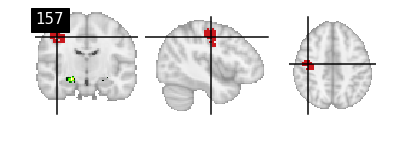

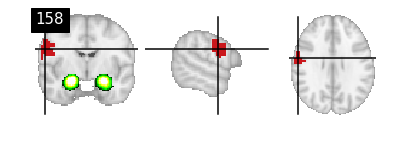

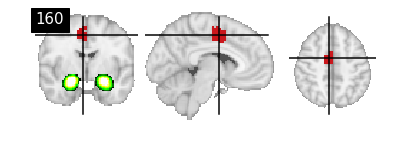

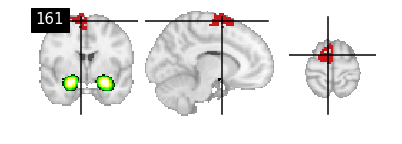

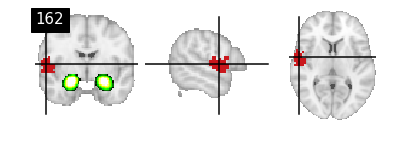

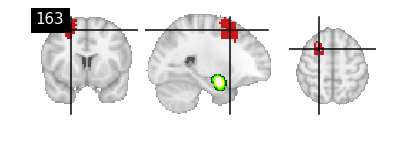

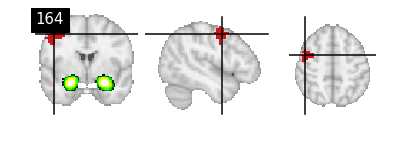

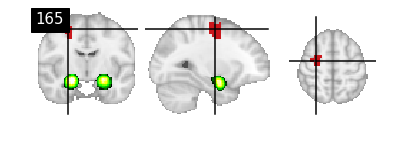

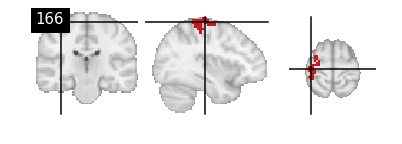

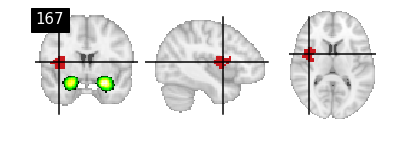

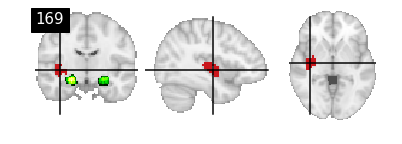

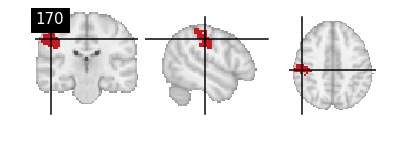

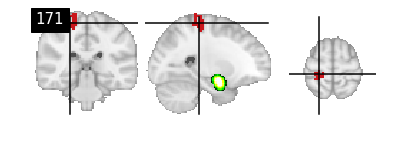

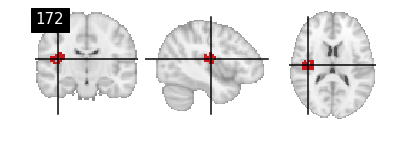

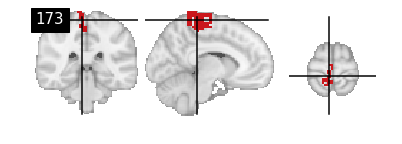

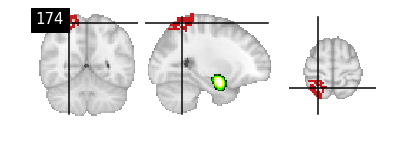

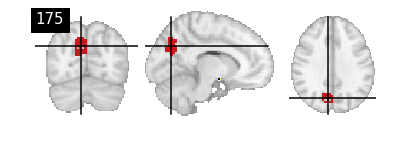

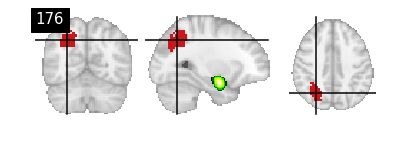

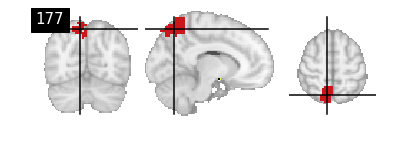

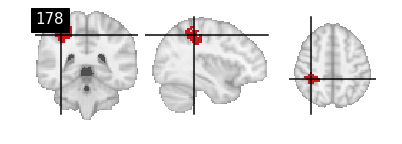

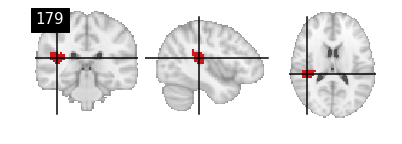

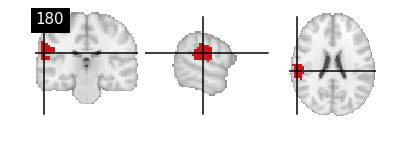

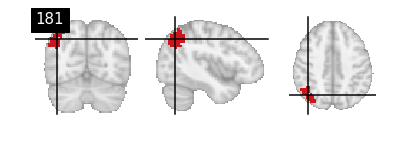

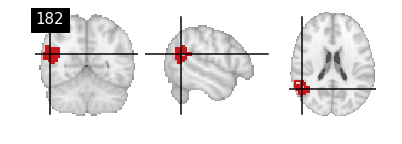

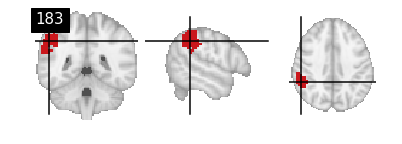

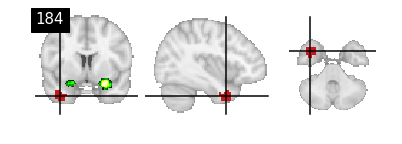

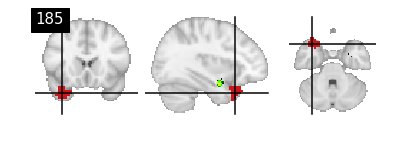

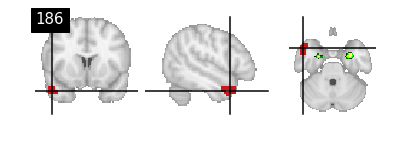

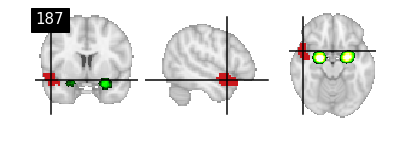

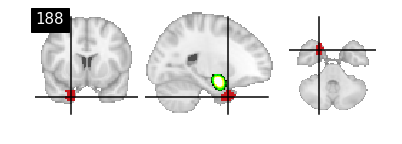

KeyboardInterrupt: 

In [141]:
amy = '/Users/Ralf/Desktop/amygdala_association-test_z_FDR_0.01.nii'

for curr_region in range(268):
    #print(curr_region)

    # plot where that region is
    shen_dictionary = np.load(shen_dictionary_file).item()
    #shen_dictionary[curr_region]['name'] 

    region_vector = np.zeros((1,268))
    region_vector[0,curr_region] = 0.5

    region_img = shen_masker.inverse_transform(region_vector);

    curr_title = shen_dictionary[curr_region + 1]['name'] 
    curr_coords = shen_dictionary[curr_region + 1]['coords'] 
    
    #'''
    f = plt.figure(figsize = (14,2))
    ax1 = f.add_subplot(121)
    
    display = nilearn.plotting.plot_stat_map(nilearn.image.index_img(region_img,0), 
                                       threshold = 0.4, 
                                       vmax = 1., 
                                       draw_cross = True,
                                       colorbar = False,
                                       cmap = 'Reds',
                                       annotate = False,
                                       cut_coords = curr_coords,
                                       title = str(curr_region),
                                       axes = ax1);
    
    display.add_overlay(amy,
                        threshold = 12,
                        cmap=plotting.cm.black_green) 
    plt.show()
   

In [147]:
curr_region = 96

region_vector = np.zeros((1,268))
region_vector[0,curr_region] = 0.5

region_img = shen_masker.inverse_transform(region_vector);


view = nilearn.plotting.view_img(nilearn.image.index_img(region_img,0),
                               threshold = 0.4,
                               resampling_interpolation = 'linear',
                               vmax = 0.6,
                               title = 'diff');

view

In [ ]:
shen_masker = NiftiLabelsMasker(labels_img=shen_atlas_filename);
shen_masker.fit_transform(sample_file);


comp_isc_act = np.zeros((268,2))

for curr_region in range(5):
    #print(curr_region)

    # plot where that region is
    shen_dictionary = np.load(shen_dictionary_file).item()
    #shen_dictionary[curr_region]['name'] 

    region_vector = np.zeros((1,268))
    region_vector[0,curr_region] = 0.5

    region_img = shen_masker.inverse_transform(region_vector);

    curr_title = shen_dictionary[curr_region + 1]['name'] 
    curr_coords = shen_dictionary[curr_region + 1]['coords'] 
    
    #'''
    f = plt.figure(figsize = (14,2))
    ax1 = f.add_subplot(121)
    
    nilearn.plotting.plot_stat_map(nilearn.image.index_img(region_img,0), 
                                       threshold = 0.4, 
                                       vmax = 1., 
                                       draw_cross = True,
                                       colorbar = False,
                                       cmap = 'Greens',
                                       annotate = False,
                                       cut_coords = curr_coords,
                                       title = str(curr_region),
                                       axes = ax1);
    #plt.show()


    #f = plt.figure(figsize=(10,5))
    ax2 = f.add_subplot(122)

    ax2.plot(scipy.stats.zscore(suspense), color = 'red',   label = 'Suspense (CRM)');
    ax2.plot(scipy.stats.zscore(dyn_isc_result_all[:,curr_region]),             color = 'green', label = 'dynISC regional (all)');
    #ax2.plot(scipy.stats.zscore(dyn_isc_result[0,:,curr_region]).T,             color = 'green', alpha = 0.3, label = 'dynISC regional (Group1)');
    #ax2.plot(scipy.stats.zscore(dyn_isc_result[1,:,curr_region]).T,            color = 'green',  alpha = 0.3, label = 'dynISC regional (Group2)');

    
    #'''
    m1 = np.mean(ts_data_undet[:, curr_region,:248], axis = 1)
    m2 = np.mean(ts_data_undet[:, curr_region, 248:], axis = 1)
    
    m_all = np.mean(ts_data_undet[:, curr_region, :], axis = 1)
    
    roll_vals = pd.DataFrame(m_all).rolling(window = 15, center = True, win_type = 'boxcar', min_periods = 5).mean()[0].values

    
    #'''
    #ax2.plot(scipy.stats.zscore(m1),            color = 'orange',  alpha = 0.3, label = 'activation regional (Group1)');
    #ax2.plot(scipy.stats.zscore(m2),            color = 'orange',  alpha = 0.3, label = 'activation regional (Group1)');

    ax2.plot(scipy.stats.zscore(roll_vals),            color = 'orange', label = 'activation regional (Group1)');

    
    #plt.legend(loc = 4)
    plt.ylim(-3, 3)
    plt.xlabel('Time')
    plt.ylabel('ACT | ISC | Suspsense')
    plt.xticks([]);
    plt.yticks([]);#'''
    

    alignment = np.corrcoef(
                    (scipy.stats.zscore(dyn_isc_result_all[:,curr_region]) ),
                     scipy.stats.zscore(suspense))[0,1]
    comp_isc_act[curr_region,0] = alignment
    
    act_alignment = np.corrcoef(
                    (scipy.stats.zscore(roll_vals) ),
                     scipy.stats.zscore(suspense))[0,1]
    comp_isc_act[curr_region,1] = act_alignment
    
    plt.title(curr_title[6:30] + ' ISC-al: ' + str(np.round(alignment,2)) + ' Act-al: ' + str(np.round(act_alignment,2)))
    sns.despine()

    #print('Alignment: ' + str(np.round(alignment,2)) )

In [154]:
# load the dictionary and create the main data structure (ts_data) as well as auxilliary variables.
read_dictionary = np.load(dict_file).item()

subjs = list(read_dictionary.keys())
n_subjs = len(subjs)

n_tr, n_regions = read_dictionary[subjs[0]]['funcdata'].shape

print(n_subjs)
print(n_tr)
print(n_regions)

ts_data = np.zeros((n_tr, n_regions, n_subjs))
ts_data_undet = np.zeros((n_tr, n_regions, n_subjs))
motion_data = np.zeros((n_tr, 6, n_subjs))
age_data = np.zeros((n_subjs))
gender_data = np.zeros((n_subjs))

#loop over viewers and fill the ts_data array

for curr_sub in range(n_subjs):
    curr_sub_name = subjs[curr_sub]
    ts_data[:,:, curr_sub] =  read_dictionary[curr_sub_name]['funcdata']
    ts_data_undet[:,:, curr_sub] =  read_dictionary[curr_sub_name]['funcdata_unfilt_undet_stand']
    motion_data[:,:, curr_sub] =  read_dictionary[curr_sub_name]['motion']
    age_data[curr_sub] = read_dictionary[curr_sub_name]['age']
    gender_data[curr_sub] = read_dictionary[curr_sub_name]['gender']

494
193
268


In [160]:
len(gender_data[gender_data ==2])

252

In [164]:
np.max(age_data)

87.0

In [162]:
242+252

494

In [173]:
np.mean(comp_isc_act[:,1])

0.3648187396030226

In [174]:
np.where(comp_isc_act[:,0] > 0.55)

(array([  2,   6,   7,   8,  10,  18,  19,  20,  27,  32,  34,  35,  46,
         85,  89, 121, 133, 142, 146, 153, 167, 183, 224, 252]),)

In [200]:

region_vector = np.zeros((1,268))
region_vector[0, np.where(comp_isc_act2[:,0] < 0.15)  ] = 0.5


small_isc_reg = shen_masker.inverse_transform(np.reshape( region_vector, (1,268) ) );
nilearn.plotting.plot_stat_map(nilearn.image.index_img(small_isc_reg,0),
                               resampling_interpolation = 'linear',
                               vmax = 1,
                               display_mode = 'z',
                               cut_coords = [-20, -10, -5, 0, 5, 10, 15, 20, 30, 40, 50],
                               title = 'smal issc2crm');

In [216]:
np.where(comp_isc_act2[:,0] > 0.79) 

(array([6]),)

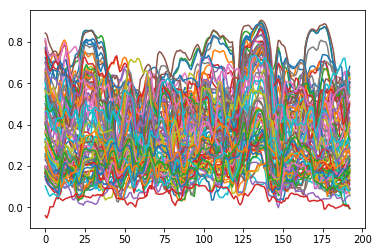

In [212]:
low = np.squeeze(dyn_isc_result_all[:,  np.where(comp_isc_act2[:,0] < 0.15) ])
plt.plot(low);

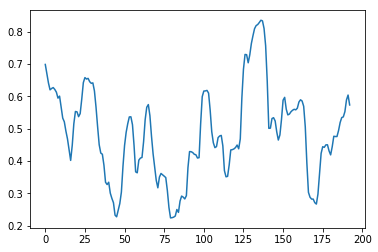

In [213]:
plt.plot(dyn_isc_result_all[:,209])